In [12]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [13]:
# putanja do foldera gdje se nalaze svi csv-ovi
DATA_PATH = r"C:/Users/ZIRA/Desktop/MASTER/RP/mahir"
# kao primjer uzeta je računica samo za New York
CITY = "New York"
# gleda se zadnjih 24 sata kao predikcija za 25-ti
WINDOW_SIZE = 24

In [14]:
# nazivi svih csv-ova unutar niza
csv_files = [
    "humidity.csv",
    "pressure.csv",
    "temperature.csv",
    "wind_direction.csv",
    "wind_speed.csv",
    "weather_description.csv"
]

# funkcija koja učitava sve csv-ove, uzima samo New York podatke i postavlja index na datetime koloni jer je ona ključna u svim csv-ovima
def load_feature(file):
    df = pd.read_csv(os.path.join(DATA_PATH, file))
    df = df[["datetime", CITY]]
    df["datetime"] = pd.to_datetime(df["datetime"])
    feature_name = file.replace(".csv", "")
    return df.rename(columns={CITY: feature_name}).set_index("datetime")

#učitavanje svih csv-ova
dfs = [load_feature(f) for f in csv_files]

In [7]:
print(load_feature('humidity.csv'));

                     humidity
datetime                     
2012-10-01 12:00:00       NaN
2012-10-01 13:00:00      58.0
2012-10-01 14:00:00      57.0
2012-10-01 15:00:00      57.0
2012-10-01 16:00:00      57.0
...                       ...
2017-11-29 20:00:00       NaN
2017-11-29 21:00:00       NaN
2017-11-29 22:00:00       NaN
2017-11-29 23:00:00       NaN
2017-11-30 00:00:00       NaN

[45253 rows x 1 columns]


In [15]:
# spajanje svih podataka iz svih csv-ova u jednu varijablu
data = pd.concat(dfs, axis=1)

In [10]:
print(data.head(10))

                     humidity  pressure  temperature  wind_direction  \
datetime                                                               
2012-10-01 12:00:00       NaN       NaN          NaN             NaN   
2012-10-01 13:00:00      58.0    1012.0   288.220000           260.0   
2012-10-01 14:00:00      57.0    1012.0   288.247676           260.0   
2012-10-01 15:00:00      57.0    1012.0   288.326940           260.0   
2012-10-01 16:00:00      57.0    1012.0   288.406203           260.0   
2012-10-01 17:00:00      57.0    1012.0   288.485467           261.0   
2012-10-01 18:00:00      56.0    1012.0   288.564730           261.0   
2012-10-01 19:00:00      56.0    1012.0   288.643994           262.0   
2012-10-01 20:00:00      56.0    1012.0   288.723257           262.0   
2012-10-01 21:00:00      55.0    1012.0   288.802521           263.0   

                     wind_speed weather_description  
datetime                                             
2012-10-01 12:00:00        

In [16]:
# popunjavanje NaN vrijednosti (gledaju se vrijednosti prije, ako ne postoje gledaju se one poslije)
data = data.ffill().bfill()

In [17]:
# one-hot encoding weather_description kolone zato sto je tekstualna
data = pd.get_dummies(data, columns=["weather_description"])

In [18]:
# ako je ostalo nesto NaN slučajno (bfill i ffill nisu odradili posao jer su sve vrijednosti NaN npr), popuni sa nulom
data = data.fillna(0)

In [19]:
# prebaci sve u tip float32 jer LSTM radi bolje sa njima
data = data.astype(np.float32)

In [20]:
# transformacija temperature u celzijuse (lakše)
data["temperature"] = data["temperature"] - 273.15

In [11]:
print(data)

                     humidity  pressure  temperature  wind_direction  \
datetime                                                               
2012-10-01 12:00:00       NaN       NaN          NaN             NaN   
2012-10-01 13:00:00      58.0    1012.0   288.220000           260.0   
2012-10-01 14:00:00      57.0    1012.0   288.247676           260.0   
2012-10-01 15:00:00      57.0    1012.0   288.326940           260.0   
2012-10-01 16:00:00      57.0    1012.0   288.406203           260.0   
...                       ...       ...          ...             ...   
2017-11-29 20:00:00       NaN       NaN          NaN             NaN   
2017-11-29 21:00:00       NaN       NaN          NaN             NaN   
2017-11-29 22:00:00       NaN       NaN          NaN             NaN   
2017-11-29 23:00:00       NaN       NaN          NaN             NaN   
2017-11-30 00:00:00       NaN       NaN          NaN             NaN   

                     wind_speed weather_description  
datetime 

In [21]:
# spremanje svih numerickih kolona osim weather_desc_ jer su one binarno kodirane
numerical_cols = [col for col in data.columns if not col.startswith("weather_description_")]
scaler = MinMaxScaler()

In [25]:
print(numerical_cols)

['humidity', 'pressure', 'temperature', 'wind_direction', 'wind_speed']


In [22]:
# skaliraju se podaci na opseg [0,1] zbog raznolikosti vrijednosti, također olakšanje za LSTM
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

In [29]:
print(data)

                     humidity  pressure  temperature  wind_direction  \
datetime                                                               
2012-10-01 12:00:00  0.533333  0.569893     0.629704        0.722222   
2012-10-01 13:00:00  0.533333  0.569893     0.629704        0.722222   
2012-10-01 14:00:00  0.522222  0.569893     0.630170        0.722222   
2012-10-01 15:00:00  0.522222  0.569893     0.631503        0.722222   
2012-10-01 16:00:00  0.522222  0.569893     0.632835        0.722222   
...                       ...       ...          ...             ...   
2017-11-29 20:00:00  0.533333  0.655914     0.575220        0.000000   
2017-11-29 21:00:00  0.533333  0.655914     0.575220        0.000000   
2017-11-29 22:00:00  0.533333  0.655914     0.575220        0.000000   
2017-11-29 23:00:00  0.533333  0.655914     0.575220        0.000000   
2017-11-30 00:00:00  0.533333  0.655914     0.575220        0.000000   

                     wind_speed  weather_description_broken clo

In [23]:
# funkcija koja kreira sekvence za time_window, uzima npr. 24 vrijednosti (X), u y smješta 25-tu kao onu koja se treba prediktovati.
def create_sequences(data, target_col, window):
    X, y = [], []
    target_idx = data.columns.get_loc(target_col)
    for i in range(len(data) - window):
        X.append(data.iloc[i:i+window].values)
        y.append(data.iloc[i+window, target_idx])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

In [24]:
target_column = "temperature"

X, y = create_sequences(data, target_column, WINDOW_SIZE)

In [46]:
print(X[1][1])
print(y[1])

[0.5222222  0.5698929  0.63016987 0.72222227 0.28       0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
0.66082716


In [33]:
print(y)

[0.6594944  0.66082716 0.6621599  ... 0.57521963 0.57521963 0.57521963]


In [25]:
print("X dtype:", X.dtype, "shape:", X.shape)
print("y dtype:", y.dtype, "shape:", y.shape)
print(len(data))

X dtype: float32 shape: (45229, 24, 41)
y dtype: float32 shape: (45229,)
45253


In [26]:
# split podataka na testne i trening
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [27]:
# kreiranje modela, kroz eksperimentisanje ovaj daje najbolje rezultate
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(WINDOW_SIZE, X.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1) 
])

In [28]:
# koristi se adam optimizer sa 20 epoha i mse kao mjerač tačnosti
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1)

pred = model.predict(X_test)

Epoch 1/20
509/509 [==============================] - 30s 53ms/step - loss: 0.0070 - val_loss: 0.0031
Epoch 2/20
509/509 [==============================] - 27s 54ms/step - loss: 0.0022 - val_loss: 9.6029e-04
Epoch 3/20
509/509 [==============================] - 26s 51ms/step - loss: 0.0015 - val_loss: 6.8224e-04
Epoch 4/20
509/509 [==============================] - 27s 54ms/step - loss: 0.0012 - val_loss: 7.1395e-04
Epoch 5/20
509/509 [==============================] - 28s 56ms/step - loss: 9.9196e-04 - val_loss: 6.2740e-04
Epoch 6/20
509/509 [==============================] - 27s 52ms/step - loss: 8.3962e-04 - val_loss: 3.7955e-04
Epoch 7/20
509/509 [==============================] - 27s 53ms/step - loss: 7.5302e-04 - val_loss: 3.5732e-04
Epoch 8/20
509/509 [==============================] - 25s 50ms/step - loss: 6.8533e-04 - val_loss: 3.7110e-04
Epoch 9/20
509/509 [==============================] - 25s 48ms/step - loss: 6.4178e-04 - val_loss: 3.3415e-04
Epoch 10/20
509/509 [=========

In [57]:
print(numerical_cols)

['humidity', 'pressure', 'temperature', 'wind_direction', 'wind_speed']


In [64]:
# funkcija koja invertuje iz opsega [0,1] nazad u normalne vrijednosti zbog jednostavnijeg čitanja
def invert_scale(pred_scaled, y_scaled, scaler, feature_name, numerical_cols):
    idx = numerical_cols.index(feature_name)
    pred_padded = np.zeros((len(pred_scaled), len(numerical_cols)))
    y_padded = np.zeros((len(y_scaled), len(numerical_cols)))
    pred_padded[:, idx] = pred_scaled.flatten()
    y_padded[:, idx] = y_scaled.flatten()
    inv_pred = scaler.inverse_transform(pred_padded)[:, idx]
    inv_y = scaler.inverse_transform(y_padded)[:, idx]
    return inv_pred, inv_y

In [65]:
pred_inv, y_test_inv = invert_scale(pred, y_test, scaler, target_column, numerical_cols)


PRED SCALED
[[0.51116735]
 [0.50064266]
 [0.4900846 ]
 ...
 [0.56905836]
 [0.56905836]
 [0.56905836]]
Y SCALED
[0.51770735 0.5062723  0.4857564  ... 0.57521963 0.57521963 0.57521963]
PADDED PRED
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
PADDED Y
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
PADDED PREDD
[[0.         0.         0.51116735 0.         0.        ]
 [0.         0.         0.50064266 0.         0.        ]
 [0.         0.         0.49008459 0.         0.        ]
 ...
 [0.         0.         0.56905836 0.         0.        ]
 [0.         0.         0.56905836 0.         0.        ]
 [0.         0.         0.56905836 0.         0.        ]]
PADDED YY
[[0.         0.         0.51770735 0.         0.        ]
 [0.         0.         0.50627232 0.         0.        ]
 [0.         0.         0.4857564  0.         0.        ]
 ...
 [0.        

MAE: 0.67
Temperature RMSE: 0.90


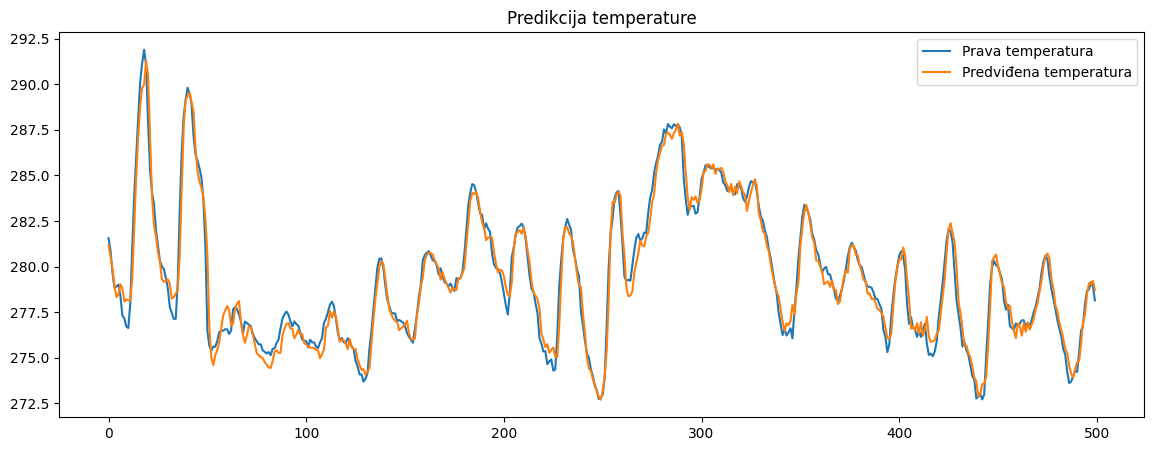

In [68]:

# koliko model pogriješi bez obzira na smjer greške (+- X celzijusa) - uzima apsolutnu vrijednost
mae = mean_absolute_error(y_test_inv, pred_inv)
print(f"MAE: {mae:.2f}")

# ista stvar kao iznad, samo sto ovdje se kvadriraju greske - veća osjetljivost na greške
rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv))
print(f"Temperature RMSE: {rmse:.2f}")

# Prikaz rezultata
plt.figure(figsize=(14, 5))
plt.plot(y_test_inv[:500], label='Prava temperatura')
plt.plot(pred_inv[:500], label='Predviđena temperatura')
plt.title("Predikcija temperature")
plt.legend()
plt.show()